# Implementing a Quantum Fourier Transform (QFT)
In this example we want to bring everything together to efficiently calculate filter functions of a QFT. We will optimize atomic gates using QuTiP and set up `PulseSequence`s with the optimized parameters. Using those, we will assemble a QFT circuit with interactions limited to nearest neighbors, thus requiring us to swap qubits around the registers to perform controlled rotations.

The circuit for the algorithm on four qubits is as follows (for simplicity we run the transformations of each qubit sequentially):

![qft.png](../_static/qft.png)

Here, unlike in the canonical circuit ([Wikipedia](https://en.wikipedia.org/wiki/Quantum_Fourier_transform#Circuit_implementation)), the qubits are already swapped when the algorithm finishes.

## Physical model
We will consider a qubit model where single-qubit operations are performed using I-Q manipulation and two-qubit operations using nearest-neighbor exchange interaction. Concretely, the single-qubit control Hamiltonian is given by

$$
H_c^{(1)}(t) = I(t)\:\sigma_x + Q(t)\:\sigma_y
$$

and the two-qubit control Hamiltonian by

$$
H_c^{(2)}(t) = I_1(t)\; \sigma_x \otimes \mathbb{1} + Q_1(t)\;\sigma_y \otimes \mathbb{1} + J(t)\:\sigma_z \otimes \sigma_z + I_2(t)\; \mathbb{1} \otimes \sigma_x + Q_2(t)\;\mathbb{1} \otimes \sigma_y.
$$

## Optimizing pulses using GRAPE
We would like to keep the size of our optimized gate set as small as possible and thus compile the required gates from the set $\left\lbrace\mathrm{X(\pi/2)}, \mathrm{Y(\pi/2)}, \mathrm{CZ(\pi/2^3)}\right\rbrace$ for a four-qubit QFT.

In [1]:
import numpy as np
import qutip as qt
from qutip.control import pulseoptim
from qutip.qip import operations

import filter_functions as ff

np.random.seed(10)
n_qubits = 4
# Single-qubit control Hamiltonian
H_c_single = [
    qt.sigmax(),
    qt.sigmay()
]
# Initial unitary
U_0_single = qt.qeye(2)
# No constant terms
H_d_single = U_0_single*0

# Two-qubit control Hamiltonian
H_c_two = [
    qt.tensor(qt.sigmax(), qt.qeye(2)),
    qt.tensor(qt.sigmay(), qt.qeye(2)),
    qt.tensor(qt.qeye(2), qt.sigmax()),
    qt.tensor(qt.qeye(2), qt.sigmay()),
    qt.tensor(qt.sigmaz(), qt.sigmaz())
]
# Initial unitary
U_0_two = qt.tensor(qt.qeye(2), qt.qeye(2))
# No constant terms
H_d_two = U_0_two*0

# Define the target unitaries
target_gates = {
    'X_pi2': operations.rotation(qt.sigmax(), np.pi/2),
    'Y_pi2': operations.rotation(qt.sigmay(), np.pi/2),
    'CZ_pi8': operations.cphase(np.pi/2**(n_qubits - 1)) 
}
H_c = {
    'X_pi2': H_c_single,
    'Y_pi2': H_c_single,
    'CZ_pi8': H_c_two,
}
H_d = {
    'X_pi2': H_d_single,
    'Y_pi2': H_d_single,
    'CZ_pi8': H_d_two,
}
U_0 = {
    'X_pi2': U_0_single,
    'Y_pi2': U_0_single,
    'CZ_pi8': U_0_two,    
}

# Define some optimization parameters
t_sample = 1
n_sample = 30
t_clock = t_sample*n_sample

optim_options = dict(
    alg='GRAPE',                          # algorithm (could also do CRAB)
    num_tslots=n_sample,                  # number of time steps
    evo_time=t_clock,                     # total evolution time
    amp_lbound=0,                         # amplitudes should be positive
    fid_err_targ=1e-12,                   # target overlap
    max_iter=10**5,                       # maximum number of iterations
    init_pulse_type='RND',                # initial amplitude shapes
    init_pulse_params=dict(num_waves=2),  # number of wavelengths of init pulse
    phase_option='PSU',                   # ignore global phase
    method_params=dict(tol=1e-10),        # tolerance
)

grape_results = {
    name: pulseoptim.optimize_pulse_unitary(
        H_d=H_d[name],
        H_c=H_c[name],
        U_0=U_0[name],
        U_targ=target,
        **optim_options
    ) for name, target in target_gates.items()
}

With the pulses optimized, we can now set up the `PulseSequence`s for each and assert their correct action:

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X_pi2 	: (True, -3.141592653589793)
Y_pi2 	: (True, 3.141592653589793)
CZ_pi8 	: (True, -1.4726215563702136)


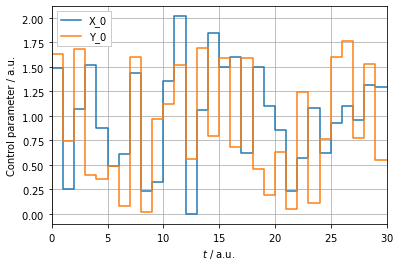

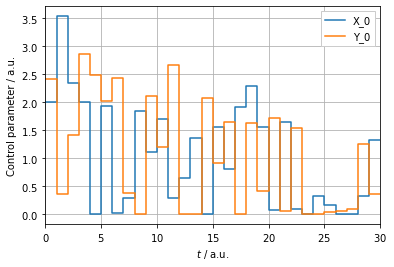

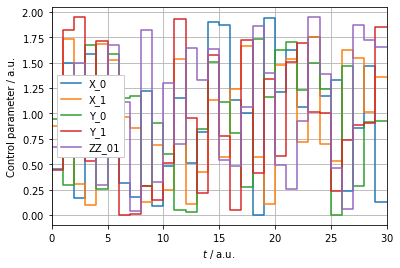

In [2]:
from filter_functions import plotting

identifiers = {
    'X_pi2': ['X_0', 'Y_0'],
    'Y_pi2': ['X_0', 'Y_0'],
    'CZ_pi8': ['X_0', 'Y_0', 'X_1', 'Y_1', 'ZZ_01']
}
pulses = {}
for name, result in grape_results.items():
    pulse = ff.PulseSequence(
        list(zip(H_c[name], result.final_amps.T, identifiers[name])),
        list(zip(H_c[name], np.ones((len(H_c[name]), n_sample)), identifiers[name])),
        [t_clock/n_sample]*n_sample,
        basis=ff.Basis.pauli(int(np.log2(U_0[name].shape[0])))
    )
    pulses[name] = pulse
    
    print(name, '\t:', ff.util.oper_equiv(
        pulse.total_propagator, target_gates[name], eps=1e-9
    ))
    _ = plotting.plot_pulse_train(pulse)

## Assembling the circuit
For simplicity, we are going to assume periodic boundary conditions, i.e., the qubits sit on a ring such that each qubit has two nearest neighbors. This allows us to make the best use of the caching of filter functions.

To this end, we first explicitly cache the control matrices for the optimized, elementary pulses and then extend them to the four-qubit Hilbert space.

In [3]:
omega = np.geomspace(1e-4, 1e2, 200)
spectrum = 1e-10/omega

print('Caching control matrices for single- and two-qubit pulses:')
pulses['X_pi2'].cache_control_matrix(omega, show_progressbar=True)
pulses['Y_pi2'].cache_control_matrix(omega, show_progressbar=True)
pulses['CZ_pi8'].cache_control_matrix(omega, show_progressbar=True)

Caching control matrices for single- and two-qubit pulses:


C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Extending single- and two-qubit pulses to the four-qubit register
In order to extend the pulses, we first need to define the noise Hamiltonians on the other qubits so that each four-qubit pulse has the complete set of noise operators.

In [4]:
IDs = [qt.qeye(2)]*(n_qubits - 1)
four_qubit_X = [
    qt.tensor(*(IDs[:i] + [qt.sigmax()] + IDs[i:]))
    for i in range(1, n_qubits)
]
four_qubit_Y = [
    qt.tensor(*(IDs[:i] + [qt.sigmay()] + IDs[i:]))
    for i in range(1, n_qubits)
]
four_qubit_ZZ = [
    qt.tensor(*(IDs[:i] + [qt.sigmaz()]*2 + IDs[i:-1]))
    for i in range(n_qubits - 1)
] + [qt.tensor(*([qt.sigmaz()] + IDs[:n_qubits-2] + [qt.sigmaz()]))]

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
X_identifiers = [f'X_{q}' for q in range(1, n_qubits)]
Y_identifiers = [f'Y_{q}' for q in range(1, n_qubits)]
ZZ_identifiers = [f'ZZ_{q}{(q + 1) % n_qubits}' for q in range(n_qubits)]

# Identifier mapping maps every identifier to itself since we do not change the
# qubit the pulse acts on, only extend the Hilbert space
identifier_mapping = {identifier: identifier for identifier 
                      in pulses['CZ_pi8'].n_oper_identifiers}
# Additional noise Hamiltonian for one-qubit pulses
H_n_one = (
    list(zip(four_qubit_X, np.ones((n_qubits-1, n_sample)), X_identifiers)) +
    list(zip(four_qubit_Y, np.ones((n_qubits-1, n_sample)), Y_identifiers)) +
    list(zip(four_qubit_ZZ, np.ones((n_qubits, n_sample)), ZZ_identifiers))
)
# Additional noise Hamiltonian for two-qubit pulse
H_n_two = (
    list(zip(four_qubit_X[1:], np.ones((n_qubits-2, n_sample)), X_identifiers[1:])) +
    list(zip(four_qubit_Y[1:], np.ones((n_qubits-2, n_sample)), Y_identifiers[1:])) +
    list(zip(four_qubit_ZZ[1:], np.ones((n_qubits-1, n_sample)), ZZ_identifiers[1:]))
)

# Extend the pulses to four qubits and cache the filter functions for the
# dditional noise operators
four_qubit_pulses = {name: {} for name in pulses.keys()}
print('Caching control matrices for four-qubit pulses:')
four_qubit_pulses['X_pi2'][0] = ff.extend([(pulses['X_pi2'], 0, identifier_mapping)],
                                          N=n_qubits, omega=omega, 
                                          additional_noise_Hamiltonian=H_n_one,
                                          cache_filter_function=True,
                                          show_progressbar=True)
four_qubit_pulses['Y_pi2'][0] = ff.extend([(pulses['Y_pi2'], 0, identifier_mapping)],
                                          N=n_qubits, omega=omega, 
                                          additional_noise_Hamiltonian=H_n_one,
                                          cache_filter_function=True,
                                          show_progressbar=True)
four_qubit_pulses['CZ_pi8'][(0, 1)] = ff.extend([(pulses['CZ_pi8'], (0, 1), identifier_mapping)],
                                                N=n_qubits, omega=omega,
                                                additional_noise_Hamiltonian=H_n_two,
                                                cache_filter_function=True,
                                                show_progressbar=True)

print('Correct action:')
print('X_pi2: ', ff.util.oper_equiv(four_qubit_pulses['X_pi2'][0].total_propagator,
                                    operations.rotation(qt.sigmax(), np.pi/2, N=4)))
print('Y_pi2: ', ff.util.oper_equiv(four_qubit_pulses['Y_pi2'][0].total_propagator,
                                    operations.rotation(qt.sigmay(), np.pi/2, N=4)))
print('CZ_pi8: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi8'][(0, 1)].total_propagator,
                                     operations.cphase(np.pi/2**3, N=4), eps=1e-9))

Caching control matrices for four-qubit pulses:


C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Correct action:
X_pi2:  (True, -3.141592653589793)
Y_pi2:  (True, 3.141592653589793)
CZ_pi8:  (True, -1.4726215563702136)


### Compiling the required gates
Next, we compile all required single- and two-qubit gates from our elementary pulses. The Hadamard is given by

$$
    \mathrm{H}\doteq\mathrm{X(\pi/2)}\circ\mathrm{X(\pi/2)}\circ\mathrm{Y(\pi/2)},
$$

the controlled-X by

$$
    \mathrm{CX_{ij}(\phi)}\doteq\mathrm{H_j}\circ\mathrm{CZ_{ij}(\phi)}\circ\mathrm{H_j},
$$

and finally the SWAP by

$$
    \mathrm{SWAP_{ij}}\doteq\mathrm{CX_{ij}(\pi)}\circ\mathrm{CX_{ji}(\pi)}\circ\mathrm{CX_{ij}(\pi)}.
$$

Trivially, controlled rotations about multiples of $\pi/2^4$ are implemented by repeated applications of $\mathrm{CZ(\pi/2^4)}$.

In [6]:
four_qubit_pulses['hadamard'] = {}
four_qubit_pulses['CZ_pi4'] = {}
four_qubit_pulses['CZ_pi2'] = {}
four_qubit_pulses['CZ_pi'] = {}
four_qubit_pulses['CX_pi'] = {}
four_qubit_pulses['swap'] = {}

four_qubit_pulses['hadamard'][0] = ff.concatenate((four_qubit_pulses['Y_pi2'][0],
                                                   four_qubit_pulses['X_pi2'][0],
                                                   four_qubit_pulses['X_pi2'][0]),
                                                  show_progressbar=True)
four_qubit_pulses['CZ_pi4'][(0, 1)] = ff.concatenate((four_qubit_pulses['CZ_pi8'][(0, 1)],
                                                      four_qubit_pulses['CZ_pi8'][(0, 1)]),
                                                     show_progressbar=True)
four_qubit_pulses['CZ_pi2'][(0, 1)] = ff.concatenate((four_qubit_pulses['CZ_pi4'][(0, 1)],
                                                      four_qubit_pulses['CZ_pi4'][(0, 1)]),
                                                     show_progressbar=True)
four_qubit_pulses['CZ_pi'][(0, 1)] = ff.concatenate((four_qubit_pulses['CZ_pi2'][(0, 1)],
                                                     four_qubit_pulses['CZ_pi2'][(0, 1)]),
                                                    show_progressbar=True)
# CNOT with control on the second, target on the first qubit
four_qubit_pulses['CX_pi'][(1, 0)] = ff.concatenate((four_qubit_pulses['hadamard'][0],
                                                     four_qubit_pulses['CZ_pi'][(0, 1)],
                                                     four_qubit_pulses['hadamard'][0]),
                                                    show_progressbar=True)

print('Correct action:')
print('hadamard: ', ff.util.oper_equiv(four_qubit_pulses['hadamard'][0].total_propagator,
                                       operations.snot(4, 0), eps=1e-9))
print('CZ_pi4: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi4'][(0, 1)].total_propagator,
                                     operations.cphase(np.pi/2**2, N=4), eps=1e-8))
print('CZ_pi2: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi2'][(0, 1)].total_propagator,
                                     operations.cphase(np.pi/2**1, N=4), eps=1e-7))
print('CZ_pi: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi'][(0, 1)].total_propagator,
                                    operations.cphase(np.pi/2**0, N=4), eps=1e-7))
print('CX_pi: (1, 0)', ff.util.oper_equiv(four_qubit_pulses['CX_pi'][(1, 0)].total_propagator,
                                          operations.cnot(4, 1, 0), eps=1e-7))

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Correct action:
hadamard:  (True, -1.5707963267948961)
CZ_pi4:  (True, -2.9452431127404273)
CZ_pi2:  (True, 0.3926990816987326)
CZ_pi:  (True, 0.785398163397473)
CX_pi: (1, 0) (True, -2.3561944901923164)


### Remapping pulses to different qubits
To get the CNOT with control and target interchanged, we simply remap the Hadamard pulse to the first qubit by cyclically moving the qubits

In [7]:
def cyclical_mapping(shift: int):
    """Shift qubit indices of identifiers by shift"""
    mapping = {}
    mapping.update({f'X_{i}': f'X_{(i+shift) % n_qubits}'
                    for i in range(n_qubits)})
    mapping.update({f'Y_{i}': f'Y_{(i+shift) % n_qubits}'
                    for i in range(n_qubits)})
    mapping.update({f'ZZ_{i}{(i+1) % n_qubits}': 
                    f'ZZ_{(i+shift) % n_qubits}{(i+shift+1) % n_qubits}'
                    for i in range(n_qubits)})
    return mapping

four_qubit_pulses['hadamard'][1] = ff.remap(four_qubit_pulses['hadamard'][0],
                                            order=(3, 0, 1, 2),
                                            oper_identifier_mapping=cyclical_mapping(1))
four_qubit_pulses['CX_pi'][(0, 1)] = ff.concatenate((four_qubit_pulses['hadamard'][1],
                                                     four_qubit_pulses['CZ_pi'][(0, 1)],
                                                     four_qubit_pulses['hadamard'][1]),
                                                    show_progressbar=True)
four_qubit_pulses['swap'][(0, 1)] = ff.concatenate((four_qubit_pulses['CX_pi'][(1, 0)],
                                                    four_qubit_pulses['CX_pi'][(0, 1)],
                                                    four_qubit_pulses['CX_pi'][(1, 0)]),
                                                   show_progressbar=True)

print('Correct action:')
print('hadamard: (1)', ff.util.oper_equiv(four_qubit_pulses['hadamard'][1].total_propagator,
                                          operations.snot(4, 1), eps=1e-9))
print('CX_pi: (0, 1)', ff.util.oper_equiv(four_qubit_pulses['CX_pi'][(0, 1)].total_propagator,
                                          operations.cnot(4, 0, 1), eps=1e-7))
print('swap: (0, 1)', ff.util.oper_equiv(four_qubit_pulses['swap'][(0, 1)].total_propagator,
                                         operations.swap(4, [0, 1]), eps=1e-6))

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Correct action:
hadamard: (1) (True, -1.5707963267948961)
CX_pi: (0, 1) (True, -2.356194490192318)
swap: (0, 1) (True, -0.7853981633974528)


Now we can simply remap the four-qubit pulses to apply to qubits other than 0 and 1:

In [8]:
for q in range(2, n_qubits):
    # We remap the operators cyclically
    order = np.roll(range(n_qubits), q)
    mapping = cyclical_mapping(q)
    four_qubit_pulses['hadamard'][q] = ff.remap(four_qubit_pulses['hadamard'][0],
                                                order,
                                                oper_identifier_mapping=mapping)
for q in range(1, n_qubits-1):
    order = np.roll(range(n_qubits), q)
    mapping = cyclical_mapping(q)
    four_qubit_pulses['CZ_pi8'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi8'][(0, 1)],
                                                     order,
                                                     oper_identifier_mapping=mapping)
    four_qubit_pulses['CZ_pi4'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi4'][(0, 1)],
                                                     order,
                                                     oper_identifier_mapping=mapping)
    four_qubit_pulses['CZ_pi2'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi2'][(0, 1)],
                                                     order,
                                                     oper_identifier_mapping=mapping)
    four_qubit_pulses['CZ_pi'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi'][(0, 1)],
                                                    order,
                                                    oper_identifier_mapping=mapping)
    four_qubit_pulses['CX_pi'][(q, q+1)] = ff.remap(four_qubit_pulses['CX_pi'][(0, 1)],
                                                    order,
                                                    oper_identifier_mapping=mapping)
    four_qubit_pulses['CX_pi'][(q, q-1)] = ff.remap(four_qubit_pulses['CX_pi'][(1, 0)],
                                                    order,
                                                    oper_identifier_mapping=mapping)
    four_qubit_pulses['swap'][(q, q+1)] = ff.remap(four_qubit_pulses['swap'][(0, 1)],
                                                   order,
                                                   oper_identifier_mapping=mapping)

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Grouping reoccuring gates
As a last step before finally calculating the complete pulse we precompute pulses that appear in the algorithm multiple times in order to salvage the concatenation performance gain. As a first step, we can precompute the gates $\mathrm{SWAP_{10}}\circ\mathrm{CZ_{10}(\pi/2)}\circ\mathrm{H_0}$ and $\mathrm{SWAP_{21}}\circ\mathrm{CZ_{21}(\pi/4)}$ as depicted below:

![qft-HR2R3-boxed-separately.png](../_static/qft_HR2R3_boxed_separately.png)

Afterwards, we can precompute the gate combination $\mathrm{SWAP_{21}}\circ\mathrm{CZ_{21}(\pi/4)}\circ\mathrm{SWAP_{10}}\circ\mathrm{CZ_{10}(\pi/2)}\circ\mathrm{H_0}$ from those pulses:

![qft-HR2R3-boxed.png](../_static/qft_HR2R3_boxed.png)

In [9]:
four_qubit_pulses['hadamard-CZ_pi2-swap'] = {}
four_qubit_pulses['hadamard-CZ_pi2-swap'][(0, 1)] = ff.concatenate(
    (four_qubit_pulses['hadamard'][0],
     four_qubit_pulses['CZ_pi2'][(0, 1)],
     four_qubit_pulses['swap'][(0, 1)]),
    show_progressbar=True
)
four_qubit_pulses['CZ_pi4-swap'] = {}
four_qubit_pulses['CZ_pi4-swap'][(1, 2)] = ff.concatenate(
    (four_qubit_pulses['CZ_pi4'][(1, 2)],
     four_qubit_pulses['swap'][(1, 2)]),
    show_progressbar=True
)
four_qubit_pulses['CZ_pi8-swap'] = {}
four_qubit_pulses['CZ_pi8-swap'][(2, 3)] = ff.concatenate(
    (four_qubit_pulses['CZ_pi8'][(2, 3)],
     four_qubit_pulses['swap'][(2, 3)]),
    show_progressbar=True
)
four_qubit_pulses['hadamard-CZ_pi2-swap-CZ_pi4-swap'] = {}
four_qubit_pulses['hadamard-CZ_pi2-swap-CZ_pi4-swap'][(0, 1, 2)] = ff.concatenate(
    (four_qubit_pulses['hadamard-CZ_pi2-swap'][(0, 1)],
     four_qubit_pulses['CZ_pi4-swap'][(1, 2)]),
    show_progressbar=True
)

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


At last we can concatenate those pulses to get the quantum fourier transform and plot the filter function.

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Correct action: (True, -1.6689710972200318)
Trace fidelity: 0.9999999420442965
Filter function cached: True


(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x21d2ea1b520>)

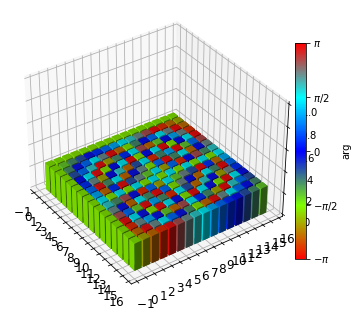

In [10]:
qft_pulse = ff.concatenate(
    (four_qubit_pulses['hadamard-CZ_pi2-swap-CZ_pi4-swap'][(0, 1, 2)],  # rotations on first qubit
     four_qubit_pulses['CZ_pi8-swap'][(2, 3)],                          # ... 
     four_qubit_pulses['hadamard-CZ_pi2-swap-CZ_pi4-swap'][(0, 1, 2)],  # rotations on second qubit
     four_qubit_pulses['hadamard-CZ_pi2-swap'][(0, 1)],                 # rotation on third qubit
     four_qubit_pulses['hadamard'][0]),                                 # rotation on fourth qubit
    show_progressbar=True
)

from qutip.qip.algorithms.qft import qft as qt_qft
print('Correct action:',
      ff.util.oper_equiv(qt_qft(4), qft_pulse.total_propagator))
print('Trace fidelity:',
      abs(np.trace(qt_qft(4).dag().full() @ qft_pulse.total_propagator))/2**4)
print('Filter function cached:', qft_pulse.is_cached('filter function'))
qt.matrix_histogram_complex(qft_pulse.total_propagator)

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


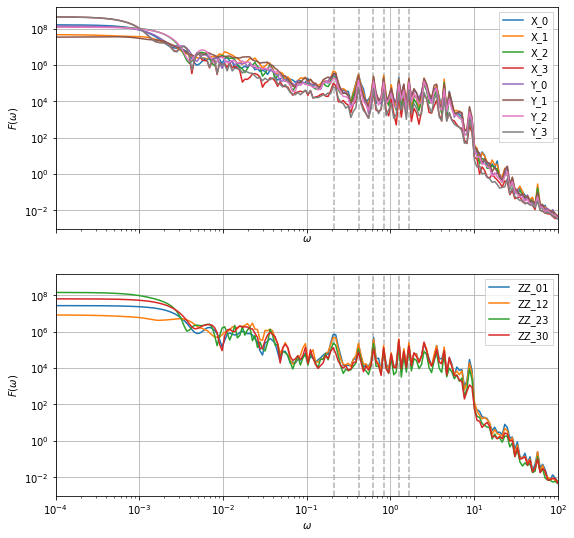

In [11]:
import matplotlib.pyplot as plt

single_qubit_identifiers = [
    i for i in qft_pulse.n_oper_identifiers if len(i) < 4
]
two_qubit_identifiers = [
    i for i in qft_pulse.n_oper_identifiers if len(i) > 4
]
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(9, 9))
_ = plotting.plot_filter_function(qft_pulse, axes=ax[0],
                                  yscale='log', omega_in_units_of_tau=False,
                                  n_oper_identifiers=single_qubit_identifiers)
_ = plotting.plot_filter_function(qft_pulse, axes=ax[1],
                                  yscale='log', omega_in_units_of_tau=False,
                                  n_oper_identifiers=two_qubit_identifiers)

for n in (1, 2, 3, 4, 6, 8):
    ax[0].axvline(n*2*np.pi/30, color='k', zorder=0, linestyle='--', alpha=0.3)
    ax[1].axvline(n*2*np.pi/30, color='k', zorder=0, linestyle='--', alpha=0.3)    

Evidently, the DC regime is dominated by the $X_3$ and $Y_3$ filter functions. This is obvious, since the third qubit idles for most of the algorithm in this circuit arrangement. In a realistic setting, the idling periods would be filled with dynamical decoupling sequences, thus cancelling most of the slow noise on the third qubit. Similarly, the $ZZ_{23}$ exchange is turned on least frequently and thus dominates the exchange filter functions.

The sharp peaks, some of which are indicated by grey dashed lines, are harmonics located at frequencies which are multiples of the inverse duration of a a single atomic pulse, $t_\mathrm{clock} = 30$, i.e. $\omega_n = 2\pi n/t_\mathrm{clock}$. Interestingly, the filter function has a baseline of around $10^4$ in the range $\omega\in[10^{-1}, 10^{1}]$ before it drops down to follow the usual $1/\omega^2$ behavior.

## Investigating pulse correlations in an algorithm
In case the noise affecting the system is temporally correlated on time scales as long or longer than the average gate duration, correlations between pulses may arise that aversely affect the fidelity of an algorithm. A simple, prime example of this is the Hahn echo, where a $\pi$-pulse is placed between two periods of free evolution. The 'correlation filter function' (see [this notebook for more details](advanced_concatenation.ipynb)) between these two free evolutions is negative at small frequencies and hence cancels slow noise to a large degree, showing that indeed the correlations can also improve the fidelity. We can analyze these effects to leading order using the `filter_functions` package.

In the following, we will investigate how adding Hahn echos to an idling qubit in the QFT circuit can affect the algorithm. Specifically, we will add two echos each (amounting to an identity in total so as not to alter the computation) before and after the two-qubit gates between qubits 2 and 3. The circuit is shown below:

![qft-with-echo.png](../_static/qft_with_echo.png)

Since we want to compute the correlation filter functions between each of the pulses implementing one of the gates in the circuit, we will not be able to use all of the computational shortcuts used above, but instead calculate the whole circuit as the concatenation of all (four-qubit) pulses. Moreover, as we only introduce echo pulses on the third qubit, we will only look at noise on $\sigma_y^{(3)}$.

The only four-qubit pulses we still need to compute are those with the echoes. To do this, we again use the `extend` function. First, we calculate the four-qubit pulse for $\mathrm{CZ}_{12}(\pi/4)$ together with an echo on qubit 3; $\mathrm{X}_3(\pi)$.

In [12]:
pulses['echo'] = ff.concatenate_periodic(pulses['X_pi2'], 2)
pulses['CZ_pi4'] = ff.concatenate_periodic(pulses['CZ_pi8'], 2)

# Grab the four-qubit noise Hamiltonian from echo-free pulse
H_n_all  = list(zip(four_qubit_pulses['CZ_pi4'][(0, 1)].n_opers,
                    four_qubit_pulses['CZ_pi4'][(0, 1)].n_coeffs,
                    four_qubit_pulses['CZ_pi4'][(0, 1)].n_oper_identifiers))

four_qubit_pulses['CZ_pi4_echo'] = {}
four_qubit_pulses['CZ_pi4_echo'][(1, 2)] = ff.extend(
    [(pulses['echo'], 3, cyclical_mapping(3)),
     (pulses['CZ_pi4'], (1, 2), cyclical_mapping(1))],
    N=n_qubits,
    omega=omega,
    additional_noise_Hamiltonian=[[o, c, i] for o, c, i in H_n_all if i not in
                                  ['X_1', 'X_2', 'X_3', 'Y_1', 'Y_2', 'Y_3', 'ZZ_12']],
    cache_filter_function=True,
    show_progressbar=True
)

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To match the timings (a $\pi$ pulse built from two $\pi/2$ pulses takes less time than the $\mathrm{CZ}(\pi/2)$ rotation), we introduce an idling pulse during which all controls are switched off.

In [13]:
idle = ff.PulseSequence(
    list(zip(H_c_single, np.zeros((2, n_sample)), identifiers['X_pi2'])),
    list(zip(H_c_single, np.ones((2, n_sample)), identifiers['X_pi2'])),
    [t_clock/n_sample]*n_sample,
    basis=ff.Basis.pauli(1)
)

pulses['echo_idle'] = ff.concatenate([idle, pulses['echo'], idle])
pulses['CZ_pi2'] = ff.concatenate_periodic(pulses['CZ_pi4'], 2)

# Grab the four-qubit noise Hamiltonian from echo-free pulse
H_n_all  = list(zip(four_qubit_pulses['CZ_pi2'][(1, 2)].n_opers,
                    four_qubit_pulses['CZ_pi2'][(1, 2)].n_coeffs,
                    four_qubit_pulses['CZ_pi2'][(1, 2)].n_oper_identifiers))

four_qubit_pulses['CZ_pi2_echo'] = {}
four_qubit_pulses['CZ_pi2_echo'][(0, 1)] = ff.extend(
    [(pulses['echo_idle'], 3, cyclical_mapping(3)),
     (pulses['CZ_pi2'], (0, 1), cyclical_mapping(0))],
    N=n_qubits,
    omega=omega,
    additional_noise_Hamiltonian=[[o, c, i] for o, c, i in H_n_all if i not in
                                  ['X_0', 'X_1', 'X_3', 'Y_0', 'Y_1', 'Y_3', 'ZZ_01']],
    cache_filter_function=True,
    show_progressbar=True
)

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we can compute the pulses including the correlation filter functions for the entire algorithm.

In [14]:
# All pulses in the regular circuit
pls = ['hadamard', 'CZ_pi2', 'swap', 'CZ_pi4', 'swap', 'CZ_pi8', 'swap',
       'hadamard', 'CZ_pi2', 'swap', 'CZ_pi4', 'swap',
       'hadamard', 'CZ_pi2', 'swap',
       'hadamard']
# All pulses including the echos
pls_echo = ['hadamard', 'CZ_pi2_echo', 'swap', 'CZ_pi4_echo', 'swap', 'CZ_pi8', 'swap',
            'hadamard', 'CZ_pi2_echo', 'swap', 'CZ_pi4_echo', 'swap',
            'hadamard', 'CZ_pi2', 'swap',
            'hadamard']
# The qubit indices in our pulse dictionaries to assemble the entire circuit
qubits = [0, (0, 1), (0, 1), (1, 2), (1, 2), (2, 3), (2, 3),
          0, (0, 1), (0, 1), (1, 2), (1, 2),
          0, (0, 1), (0, 1),
          0]

qft_pulse_correl = ff.concatenate(
    [four_qubit_pulses[pls][qubits] for pls, qubits in zip(pls, qubits)],
    calc_pulse_correlation_FF=True,
    omega=omega,
    show_progressbar=True
)
qft_pulse_echo_correl = ff.concatenate(
    [four_qubit_pulses[pls][qubits] for pls, qubits in zip(pls_echo, qubits)],
    calc_pulse_correlation_FF=True,
    omega=omega,
    show_progressbar=True
)

# Make sure the pulses still produce the correct propagator
print('Correct action:\n',
      ff.util.oper_equiv(qt_qft(4), qft_pulse_correl.total_propagator), '\n',
      ff.util.oper_equiv(qt_qft(4), qft_pulse_echo_correl.total_propagator))

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Correct action:
 (True, -1.668971097220032) 
 (True, -1.6689710972200302)


Finally, we can calculate the correlation infidelities from the corresponding filter functions just like for the regular (fidelity) filter function.

In [15]:
oneoverf_spectrum = 1e-9/omega
white_spectrum = np.ones_like(oneoverf_spectrum)

infids = {}
infids['1/f w/o echo'] = ff.infidelity(qft_pulse_correl, oneoverf_spectrum, omega,
                                       which='correlations', n_oper_identifiers=['Y_3'])
infids['1/f w/ echo'] = ff.infidelity(qft_pulse_echo_correl, oneoverf_spectrum, omega,
                                      which='correlations', n_oper_identifiers=['Y_3'])
infids['white w/o echo'] = ff.infidelity(qft_pulse_correl, white_spectrum, omega,
                                         which='correlations', n_oper_identifiers=['Y_3'])
infids['white w/ echo'] = ff.infidelity(qft_pulse_echo_correl, white_spectrum, omega,
                                        which='correlations', n_oper_identifiers=['Y_3'])
# Normalize the infidelities for white noise so that the total infidelity without
# echos is the same as for 1/f.
normalization = infids['1/f w/o echo'].sum() / infids['white w/o echo'].sum()
infids['white w/o echo'] *= normalization
infids['white w/ echo'] *= normalization

print('Total infidelities for Y noise on the third qubit:')
for k, v in infids.items():
    print(f'{k}\t{v.sum():.2e}')

Total infidelities for Y noise on the third qubit:
1/f w/o echo	8.35e-03
1/f w/ echo	3.02e-03
white w/o echo	8.35e-03
white w/ echo	9.19e-03


C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Evidently, the echos make a large difference in the case of $1/f$ noise, reducing the infidelity by a factor of 3, whereas for white noise the fidelity even slightly worsens. This is not so surprising considering that the former has more spectral weight at the small frequencies that the echos suppress.

We can now inspect the correlation infidelities that capture the contributions to the total infidelity from pairs of pulses (we abuse `plotting.plot_cumulant_function` for this).

C:\Users\Tobias\miniconda3\envs\py38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\tobias\code\filter_functions\filter_functions\plotting.py:792: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh=linthresh, vmin=Kmin, vmax=Kmax)


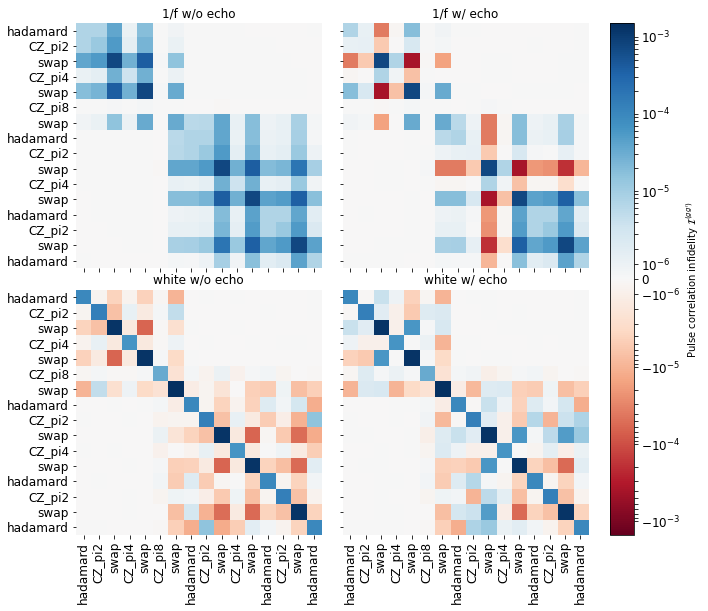

In [16]:
fig, grid = plotting.plot_cumulant_function(
    cumulant_function=np.array([infid for infid in infids.values()]).squeeze(),
    n_oper_identifiers=infids.keys(),
    colorscale='log',
    cbar_label=r"Pulse correlation infidelity $\mathcal{I}^{(gg')}$",
    basis_labels=pls,
    basis_labelsize=12,
    figsize=(10, 10)
)

# Adjust colorbar tick label size
cb = grid[-1].images[0].colorbar
cb.ax.tick_params(labelsize=12)

As we can see from the strictly positive correlation infidelities in the case of $1/f$ noise without the echos, the long noise correlation times aversely affect the algorithm and degrade its fidelity. Incorporating echo pulses introduces negative correlation infidelities between pulses before and after an echo, similar to the way that for a single Hahn echo the two periods of free evolution have negative infidelities. The magnitude of these corrections is on the level of the total infidelity itself!

For white noise, the situation is different. Here, without echo pulses there are many negative contributions for different pairs of pulses. Adding the echos produces a reverse picture to the case before: contributions that were negative before turn positive and hence deteriorate the fidelity!

This example shows that, depending on the actual noise in a system, one should carefully design one's quantum circuits in order to minimize errors.